# Astropy Sun Graph

We can clearly see diel (day/night) variation in the time/date parameter plots. 

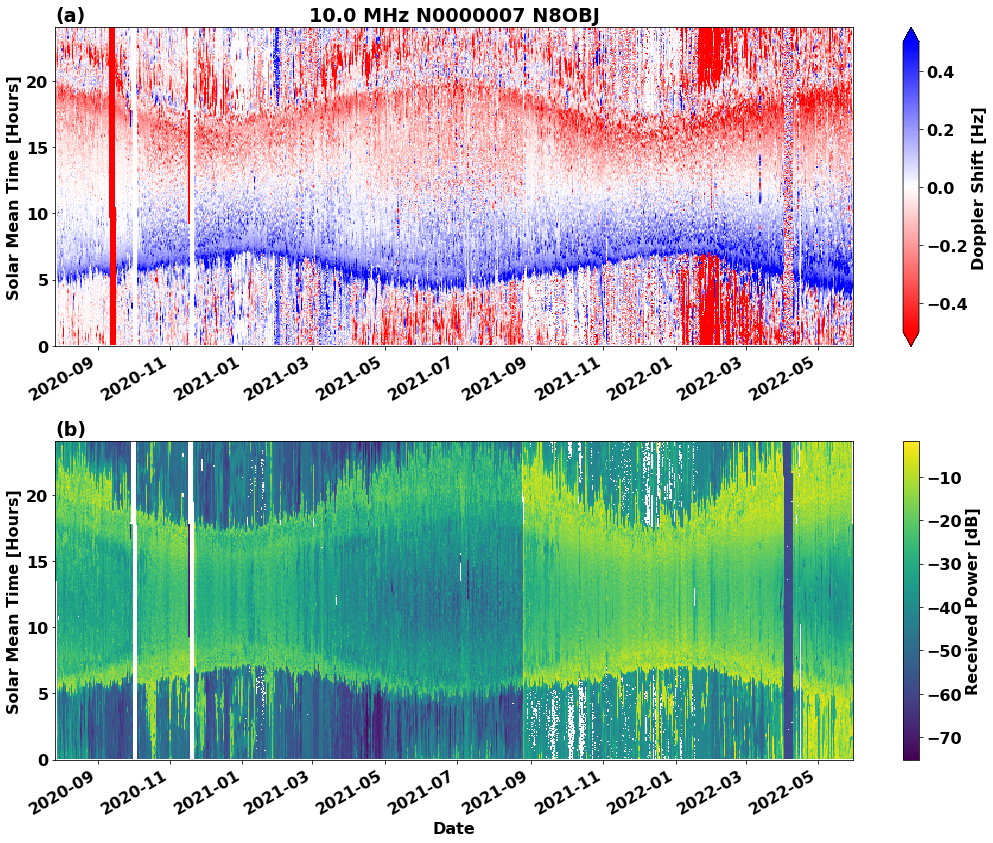

For comparison, here's a yearly sun graph for the same location. The code for this was drawn from https://adrian.pw/blog/yearly-sun-graph/.


Start and day grid are set. Computing sunrises and sunsets...
Computations completed. Plotting....


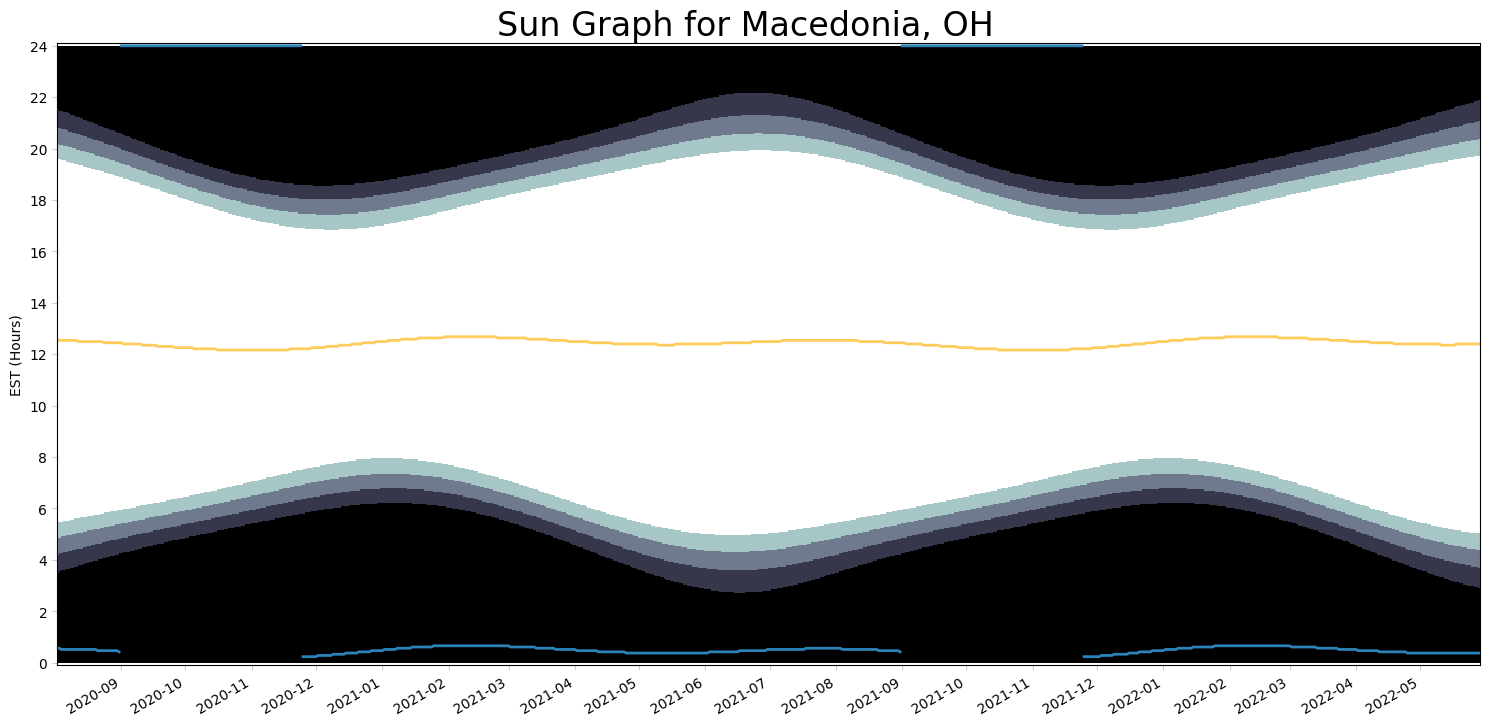

In [1]:
from datetime import datetime

# Third-party
import astropy.coordinates as coord
import astropy.units as u
import astropy.time as t
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

%matplotlib inline
import pytz

_twil = {
    "civil": [-6.0, 0] * u.degree,
    "nautical": [-12.0, -6] * u.degree,
    "astronomical": [-18.0, -12] * u.degree,
}

_twil_name_map = {"day": 0, "civil": 1, "nautical": 2, "astronomical": 3, "night": 4}

def sun_info_plot(
    earth_location, tz, start=None, day_grid=None, n_hour_grid=512, fig=None
):
    """
    Visualize how solar noon, solar midnight, and twilight (civil,
    nautical, and astronomical) vary over a range of dates at a given
    location.

    Parameters
    ----------
    earth_location : `~astropy.coordinates.EarthLocation`
        The location to produce the info for (e.g., latitude, longitude)
        as an Astropy `~astropy.coordinates.EarthLocation` object.
    tz : `~pytz.tzinfo.BaseTzInfo`
        The timezone of the location.
    start : `~astropy.time.Time`, optional
    day_grid : `~astropy.units.Quantity`, optional
    n_hour_grid : int, optional

    Returns
    -------
    fig : `matplotlib.figure.Figure`
    """

    if start is None and day_grid is None:  # default
        year = datetime.now().year
        start = t.Time("{}-01-01".format(year), format="iso", scale="utc")
        day_grid = start + np.arange(0, 365 + 1).astype(int) * u.day

    elif start is not None and day_grid is not None:
        day_grid = start + day_grid

    elif start is not None and day_grid is None:
        # day_grid = start + np.arange(0, 365 + 1).astype(int) * u.day    # 1 year plot
        day_grid = start + np.arange(0, 665 + 1).astype(int) * u.day    # specific to ESSD figure
        # day_grid = start + np.arange(0, 10 + 1).astype(int) * u.day       # code test

    elif start is None and day_grid is not None:
        year = datetime.now().year
        start = t.Time("{}-01-01".format(year), format="iso", scale="utc")
        day_grid = start + day_grid

    else:  # should never reach here
        raise ValueError("How did I get here?")

    twil_grid = np.zeros((len(day_grid), n_hour_grid), dtype=int)
    _solar_noon = []
    _solar_midnight = []
    
    print('Start and day grid are set. Computing sunrises and sunsets...')
    # print(day_grid)

    for i, day in enumerate(day_grid):
        utc_offset = tz.utcoffset(day.datetime).total_seconds() * u.second
        hour_grid_loc = (
            day + np.linspace(0, 24 - 1e-7, n_hour_grid) * u.hour - utc_offset
        )
        loc_hr = [
            d.hour + d.minute / 60.0 + d.second / 3600.0
            for d in (hour_grid_loc + utc_offset).datetime
        ] * u.hour

        # get position of the Sun at all times during this day
        sun = coord.get_sun(hour_grid_loc)
        sun_altaz = sun.transform_to(coord.AltAz(location=loc))

        # solar noon and midnight
        _solar_noon.append(loc_hr[sun_altaz.alt.argmax()])  # Sun at max altitude
        _solar_midnight.append(loc_hr[sun_altaz.alt.argmin()])  # Sun at min altitude

        # civil, nautxical, astronomical twilights
        for key in _twil.keys():
            idx = (sun_altaz.alt >= _twil[key][0]) & (sun_altaz.alt < _twil[key][1])
            twil_grid[i, idx] = _twil_name_map[key]

        idx = sun_altaz.alt < _twil["astronomical"][0]
        twil_grid[i, idx] = _twil_name_map["night"]

    # convert lists of Quantity objects to Quantity arrays
    solar_noon = u.Quantity(_solar_noon)
    solar_midnight = u.Quantity(_solar_midnight)

    # -------------------------------------------------------------------
    # Plotting
    #
    print('Computations completed. Plotting....')
    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    else:
        ax = fig.axes[0]

    # matplotlib date trickery: see http://matplotlib.org/api/dates_api.html
    xlim = mdates.date2num([day_grid.datetime.min(), day_grid.datetime.max()]).tolist()
    ylim = [loc_hr.value.min(), loc_hr.value.max()]

    # use imshow to visualize the stages of daylight
    ax.imshow(
        twil_grid.T,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        cmap="bone_r",
        extent=xlim + ylim,
    )

    # don't connect discontinuities with a line, which happen when solar midnight shifts
    # from just before 00:00 to just after.
    idx = np.where(np.abs(np.diff(solar_midnight.to(u.hour).value)) >= 5)[0] + 1
    solar_midnight = np.insert(solar_midnight, idx, np.nan)
    x_midnight = np.insert(mdates.date2num(day_grid.datetime), idx, np.nan)

    ax.plot(day_grid.datetime, solar_noon, color="#fecc5c", marker=None, linewidth=2)
    ax.plot(x_midnight, solar_midnight, color="#2b83ba", marker=None, linewidth=2)

    # assign date locator / formatter to the x-axis to get proper labels
    months = mdates.MonthLocator()

    if day_grid[0].datetime.year == day_grid[-1].datetime.year:
        date_fmt = mdates.DateFormatter("%b")
        xlabel = "{:d}".format(day_grid[0].datetime.year)
    else:
        date_fmt = mdates.DateFormatter("%Y-%m")
        xlabel = ""

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    # ax.set_xlabel(xlabel, rotation=45, ha='right')
    ax.tick_params(axis='x', labelrotation=45)
    ax.yaxis.set_ticks(np.arange(0, 24 + 2, 2))
    ax.tick_params(axis="both", colors="#cccccc")
    [lbl.set_color("k") for lbl in ax.get_xticklabels() + ax.get_yticklabels()]

    ax.set_ylim(-0.1, 24.1)
    ax.set_ylabel(str(tz) + " (Hours)")
    # ax.legend(_twil_name_map, _twil)
    fig.tight_layout()
    fig.autofmt_xdate()
    return fig

address = "Macedonia, OH"
loc = coord.EarthLocation.of_address(address)
tz = pytz.timezone("EST")
start = t.Time("2020-08-02", format="iso", scale="utc")
fig = sun_info_plot(loc, tz, 
                    start, # = t.Time("2020-07-28", format="iso", scale="utc")
                    # day_grid = start + np.arange(0, 36 + 1).astype(int) * u.day
                   )
_ = fig.suptitle('Sun Graph for ' + address, fontsize=24, y=1.02)



In [2]:
# import astropy
# print(astropy.__citation__)